In [1]:
import numpy as np
import pandas as pd
import re
import sys
import pattern
import nltk
import seaborn as sns
import matplotlib. pyplot as plt
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,f1_score,make_scorer
from IPython.display import display
from pattern.en import spelling
from wordcloud import WordCloud

C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train=pd.read_csv('train_E6oV3lV.csv')
test=pd.read_csv('test_tweets_anuFYb8.csv')
final = train.append(test, ignore_index=True,sort=True)

In [3]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)    
    return input_txt   

In [4]:
# removal of @user from the texts
final['cleantweet']=np.vectorize(remove_pattern)(final['tweet'],'@[\w]*')
# removal of all special characters except hastags and other special characters
final['cleantweet'] =final['cleantweet'].str.replace('[^a-zA-Z#]', ' ')
# removal of short words
final['cleantweet']=final['cleantweet'].apply(lambda x : ' '.join([w for w in x.split(' ') if len(w)>3]))
# tokenization
tokenized_tweet = final['cleantweet'].apply(lambda x: x.split(' '))
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: cleantweet, dtype: object

In [5]:
#final['cleantweet']=final['cleantweet'].apply(lambda x: [spelling(w) for w in x.split(' ')])
# lemmatization
ls=WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [ls.lemmatize(i,pos="n") for i in x]) # lemmatize for noun
tokenized_tweet = tokenized_tweet.apply(lambda x: [ls.lemmatize(i,pos="a") for i in x]) # lemmatize for adjective
tokenized_tweet = tokenized_tweet.apply(lambda x: [ls.lemmatize(i,pos="r") for i in x]) # lemmatize for adverb
tokenized_tweet = tokenized_tweet.apply(lambda x: [ls.lemmatize(i,pos="v") for i in x]) # lemmatize for verb
tokenized_tweet.head()
for i in range(len(tokenized_tweet)):
        tokenized_tweet[i]=' '.join(tokenized_tweet[i])
final['cleantweet']=tokenized_tweet

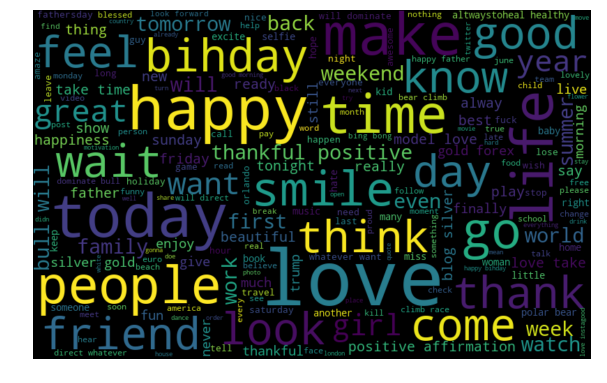

In [6]:
# Understanding common word use dion tweet
all_words=' '.join([text for text in final['cleantweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

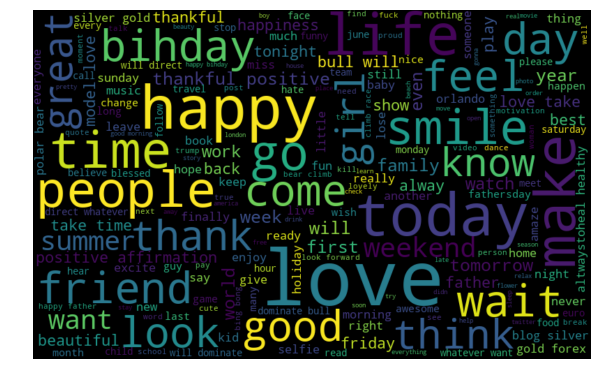

In [7]:
# gathering all non-racist/non-sexist words
normal_words=' '.join([text for text in final['cleantweet'][final['label']==0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

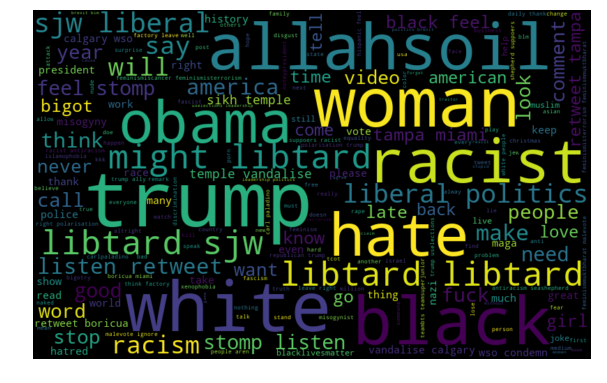

In [8]:
# gathering all racist/sexist words
racist_words=' '.join([text for text in final['cleantweet'][final['label']==1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(racist_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [9]:
# understanding importance of hashtags
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(final['cleantweet'][final['label']==0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(final['cleantweet'][final['label']==1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])
HT_regular

['run',
 'lyft',
 'disapointed',
 'getthanked',
 'model',
 'motivation',
 'allshowandnogo',
 'school',
 'exams',
 'hate',
 'imagine',
 'actorslife',
 'revolutionschool',
 'girl',
 'allin',
 'cavs',
 'champions',
 'cleveland',
 'clevelandcavaliers',
 'ireland',
 'blog',
 'silver',
 'gold',
 'forex',
 'orlando',
 'standwithorlando',
 'pulseshooting',
 'orlandoshooting',
 'biggerproblems',
 'selfish',
 'heabreaking',
 'values',
 'love',
 'gettingfed',
 'got',
 'junior',
 'yugyoem',
 'omg',
 'thankful',
 'positive',
 'friday',
 'cookies',
 'euro',
 'badday',
 'coneofshame',
 'cats',
 'pissed',
 'funny',
 'laughs',
 'wine',
 'weekend',
 'tgif',
 'gamedev',
 'indiedev',
 'indiegamedev',
 'squad',
 'upsideofflorida',
 'shopalyssas',
 'love',
 'smiles',
 'media',
 'pressconference',
 'antalya',
 'turkey',
 'throwback',
 'ica',
 'rip',
 'orlando',
 'alohafriday',
 'time',
 'not',
 'exist',
 'positivevibes',
 'hawaiian',
 'goodnight',
 'badmonday',
 'taylorswift',
 'travelingram',
 'dalat',
 'ri

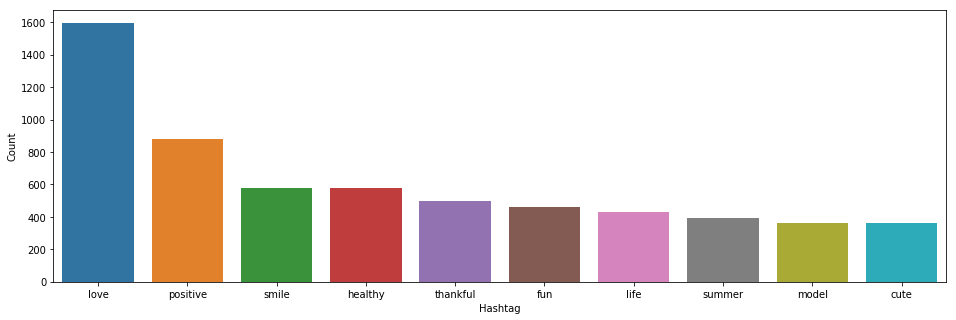

In [10]:
# plotting non-racist tweets
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

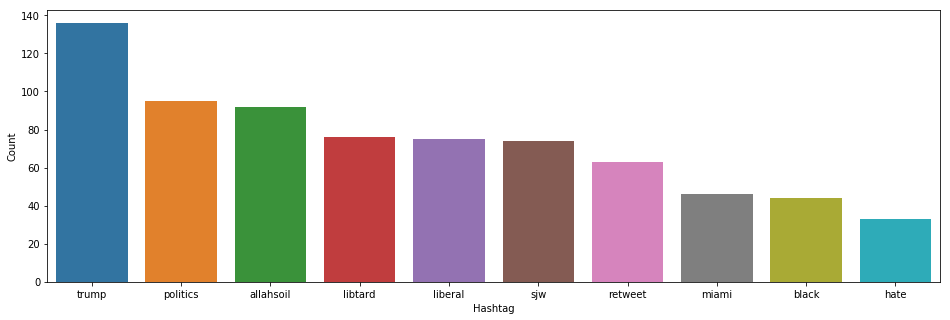

In [11]:
# plotting racist tweets
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(final['cleantweet'])

In [13]:
train_tfidf = tfidf[:31962]
test_tfidf = tfidf[31962:]
# splitting data into training and validation set
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(train_tfidf, train['label'], random_state=42, test_size=0.3)


model_name
LinearSVC                 0.949135
LogisticRegression        0.947481
MultinomialNB             0.945336
RandomForestClassifier    0.930363
Name: accuracy, dtype: float64

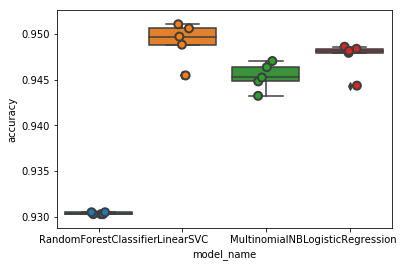

In [14]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, xtrain_tfidf, ytrain, scoring='accuracy', cv=CV) 
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
cv_df.groupby('model_name').accuracy.mean()

In [15]:
# best performing model is LinearSVC                 
model=LinearSVC()
clf=model.fit(xtrain_tfidf,ytrain)
y_pred = clf.predict(xvalid_tfidf) # predicting on the validation set
print(f1_score(yvalid, y_pred, average='weighted') )

0.9342120365330203


In [16]:
prediction = clf.predict(test_tfidf) # predicting on the validation set
test_pred_int = prediction.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]

In [17]:
submission
#submission.to_csv('test_predictions.csv')

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0
5,31968,0
6,31969,0
7,31970,0
8,31971,0
9,31972,0
